## Nasdaq & Triple Screen
**<div style="text-align: right"> author : 정호영 </div>**
삼중창 내용 보니까 꽤나 컨텐츠가 괜찮아서 미국 종목으로 한번 테스트 해보자

https://github.com/FinanceData/FinanceDataReader 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from slacker import Slacker
import time
from pandas_datareader import data as pdr 
import FinanceDataReader as fdr
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

C:\Users\user\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [ ]:
# !pip install mpl_finance

In [2]:
ticker = 'ARKK'
df = fdr.DataReader(ticker, '2018-01-01') 
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2018-01-02,38.58,37.34,38.59,37.25,420380.0,0.0405
2018-01-03,38.74,38.95,39.05,38.73,667490.0,0.0041
2018-01-04,38.87,39.10,39.19,38.48,358600.0,0.0034
2018-01-05,39.50,39.26,39.50,39.07,361640.0,0.0162
2018-01-08,39.23,39.01,39.23,38.32,421470.0,-0.0068


기존 코드와 I/O를 맞추기 위해서 변수명 변경

In [3]:
df.reset_index(drop = False, inplace = True)
df.rename(columns = {'Close':'close',
                    'Open':'open',
                    'High':'high',
                    'Low':'low',
                    'Date':'number'}, inplace = True)
df.index = df['number']
df.drop(columns = 'number', inplace = True)
df.head()

,close,open,high,low,Volume,Change
number,,,,,,
2018-01-02,38.58,37.34,38.59,37.25,420380.0,0.0405
2018-01-03,38.74,38.95,39.05,38.73,667490.0,0.0041
2018-01-04,38.87,39.10,39.19,38.48,358600.0,0.0034
2018-01-05,39.50,39.26,39.50,39.07,361640.0,0.0162
2018-01-08,39.23,39.01,39.23,38.32,421470.0,-0.0068


## FirstScreen.py

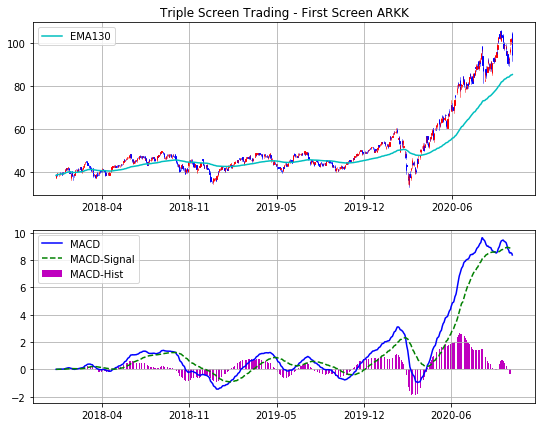

In [4]:
ema60 = df.close.ewm(span=60).mean()   # ① 종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean() # ② 종가의 12주 지수 이동평균
macd = ema60 - ema130                  # ③ MACD선
signal = macd.ewm(span=45).mean()      # ④ 신호선(MACD의 9주 지수 이동평균)
macdhist = macd - signal               # ⑤ MACD 히스토그램

df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal,
    macdhist=macdhist).dropna() 
df['number'] = df.index.map(mdates.date2num)  # ⑥
ohlc = df[['number','open','high','low','close']]

plt.figure(figsize=(9, 7))
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - First Screen %s' %ticker)
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', 
    colordown='blue')  # ⑦
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
plt.legend(loc='best')

p2 = plt.subplot(2, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.number, df['macd'], color='b', label='MACD')
plt.plot(df.number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')
plt.show()

## SecondScreen.py

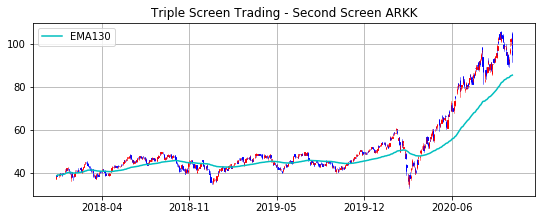

In [5]:
ndays_high = df.high.rolling(window=14, min_periods=1).max()      # ①
ndays_low = df.low.rolling(window=14, min_periods=1).min()        # ②
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100  # ③
slow_d= fast_k.rolling(window=3).mean()                           # ④
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()             # ⑤

plt.figure(figsize=(9, 7))
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - Second Screen %s' %ticker)
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
plt.legend(loc='best')

## TripleScreen.py

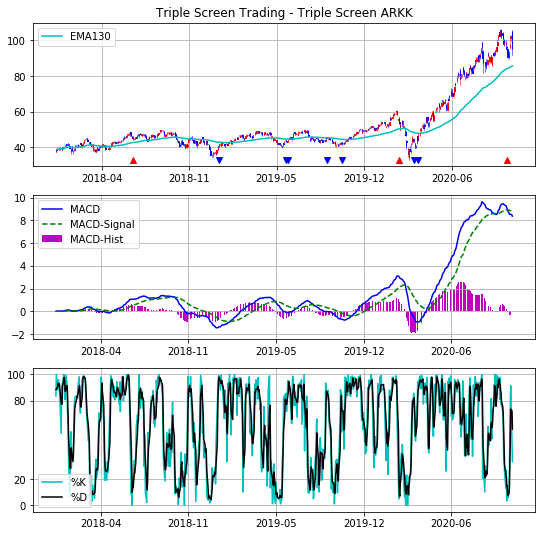

In [6]:
plt.figure(figsize=(9, 9))
p1 = plt.subplot(3, 1, 1)
plt.title('Triple Screen Trading - Triple Screen %s' %ticker)
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
for i in range(1, len(df.close)):
    # 매수
    if df.ema130.values[i-1] < df.ema130.values[i] and df.slow_d.values[i-1] >= 20 and df.slow_d.values[i] < 20:
        plt.plot(df.number.values[i], min(df['low']), 'r^')  # Constant로 박혀있는데 최저점에 표시할 예정
    # 매도
    elif df.ema130.values[i-1] > df.ema130.values[i] and df.slow_d.values[i-1] <= 80 and df.slow_d.values[i] > 80:
        plt.plot(df.number.values[i], min(df['low']), 'bv') 
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.number, df['macd'], color='b', label='MACD')
plt.plot(df.number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color='c', label='%K')
plt.plot(df.number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()